## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
# additional torch packages
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from sklearn import metrics
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import os
from glob import glob
from PIL import Image

## Import images using Rasterio

/Users/sorenbendtsen/opt/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


<class 'numpy.ndarray'>


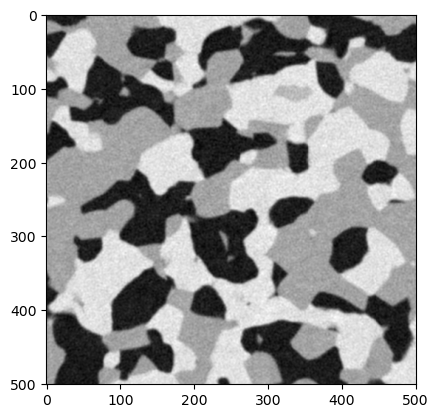

<Axes: >

In [2]:
path = 'data/SOCprist0001.tiff'

with rasterio.open(path) as image:
    image_array = image.read()
print(type(image_array))
show(image_array,cmap='gray')
#torch_image = torch.from_numpy(image_array) # gives an error..

In [16]:
# Path to the main directory containing all subdirectories with images
path_to_images = "data"

images = []
for subdirectory in os.listdir(path_to_images):
    subdirectory_path = os.path.join(path_to_images, subdirectory)
    with rasterio.open(subdirectory_path) as image:
        image_array = image.read()
        images.append(image_array)
    #print(subdirectory_path)

/Users/sorenbendtsen/opt/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


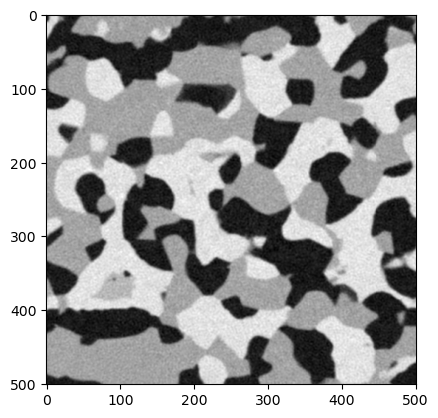

<Axes: >

In [4]:
show(images[10],cmap='gray')


In [5]:
path_to_labels = "labels"
labels = []

# Use glob to find all label files in the directory
label_files = glob(os.path.join(path_to_labels, '*.tif'))

for label_file in label_files:
    with rasterio.open(label_file) as src:
        label_array = src.read(1)  # Assuming the label data is in the first band (1-based index)
        labels.append(label_array)

# The 'with' statement will automatically close the rasterio dataset when you exit the block


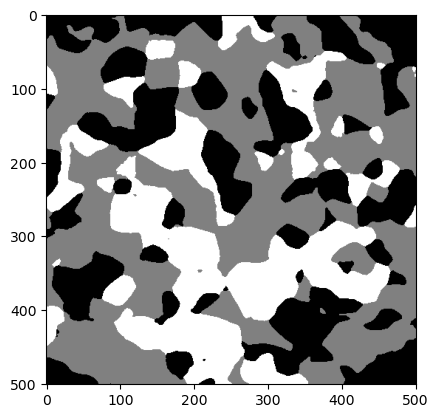

<Axes: >

In [6]:
show(labels[10],cmap='gray')

## Visualize first 10 images and their labels

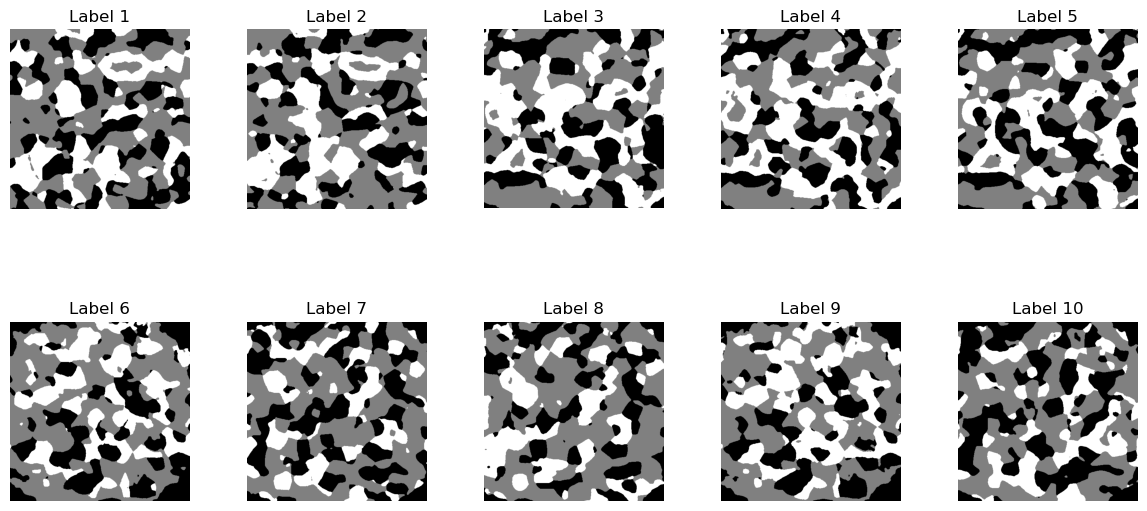

In [7]:
# Assuming you have a list of label images in the 'labels' variable
# labels[0] is the first label image, labels[1] is the second, and so on
label_images = labels[:10]  # Get the first 10 label images

# Create a figure with tight layout
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
plt.tight_layout()

# Iterate through the label images and display them in the subplots with titles
for i, ax in enumerate(axes.flat):
    if i < len(label_images):
        ax.imshow(label_images[i], cmap='gray')  # Use 'cmap' to specify the colormap (e.g., 'gray' for grayscale)
        ax.axis('off')  # Turn off the axis labels
        ax.set_title(f"Label {i+1}", fontsize=12)  # Add a title with "Image 1", "Image 2", etc.

# Show the plot
plt.show()



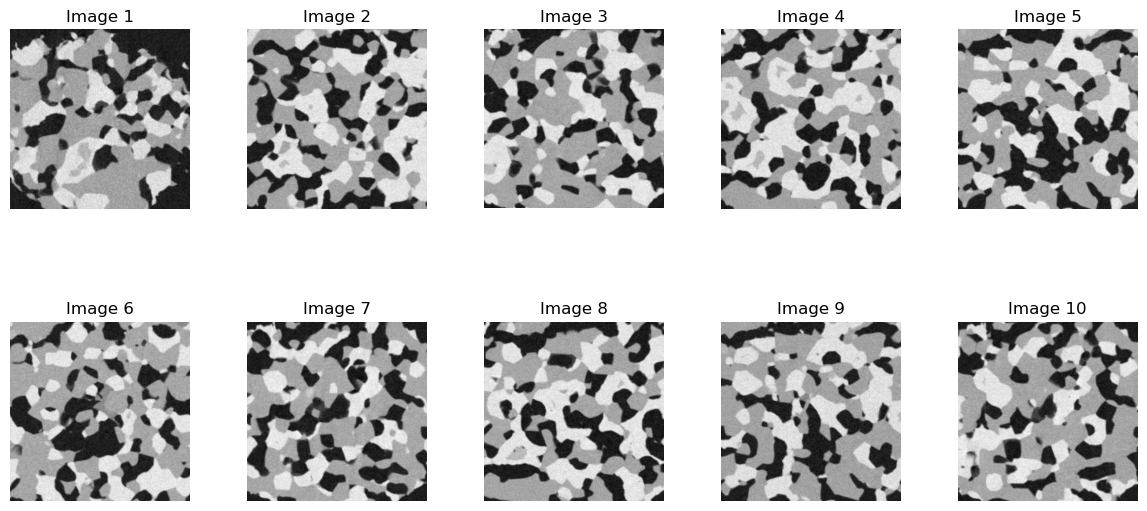

In [8]:
# Assuming you have a list of image data in the 'images' variable
# images[0] is the first image, images[1] is the second, and so on
first_10_images = images[:10]  # Get the first 10 images

# Create a figure with tight layout
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
plt.tight_layout()

# Iterate through the images and display them in the subplots with titles
for i, ax in enumerate(axes.flat):
    if i < len(first_10_images):
        image = first_10_images[i][0]  # Remove the extra dimension
        ax.imshow(image, cmap='gray')  # Use 'cmap' to specify the colormap (e.g., 'gray' for grayscale)
        ax.axis('off')  # Turn off the axis labels
        ax.set_title(f"Image {i+1}", fontsize=12)  # Add a title with "Image 1", "Image 2", etc.

# Show the plot
plt.show()


## Different import method, PIL, to get images as Tensors
As there were issues converting to Tensors when using Rasterio for import, due to data types not matching.

In [2]:
path = 'data'

images_tensors = []
for subdirectory in os.listdir(path):
    subdirectory_path = os.path.join(path, subdirectory)
    single_image = Image.open(subdirectory_path)
    single_image = ToTensor()(single_image)
    images_tensors.append(single_image)

print(len(images_tensors))
print(type(images_tensors))
print(type(images_tensors[0]))
print(images_tensors[0].shape)

500
<class 'list'>
<class 'torch.Tensor'>
torch.Size([1, 501, 501])


In [3]:
path = 'labels'

labels_tensors = []
for subdirectory in os.listdir(path):
    subdirectory_path = os.path.join(path, subdirectory)
    single_label = Image.open(subdirectory_path)
    single_label = ToTensor()(single_label)
    labels_tensors.append(single_label)

print(len(labels_tensors))
print(type(labels_tensors))
print(type(labels_tensors[0]))
print(labels_tensors[0].shape)

500
<class 'list'>
<class 'torch.Tensor'>
torch.Size([1, 501, 501])


## Data transformation
Should we transform the tensors to be within 0-1? and why?

In [37]:
print(images_tensors[0])
print(type(images_tensors[0]))

tensor([[[21357, 21656, 21301,  ..., 22812, 22163, 21752],
         [21227, 21316, 21023,  ..., 22191, 21908, 21856],
         [21292, 21180, 21098,  ..., 21435, 21353, 21517],
         ...,
         [22655, 22634, 22204,  ..., 21430, 21186, 20717],
         [22740, 22363, 21676,  ..., 20506, 20421, 20397],
         [22356, 21945, 21593,  ..., 20576, 20628, 20800]]], dtype=torch.int16)
<class 'torch.Tensor'>


In [40]:
print(labels_tensors[0])
print(type(labels_tensors[0]))

tensor([[[0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
         ...,
         [0.5020, 0.5020, 0.5020,  ..., 1.0000, 1.0000, 1.0000],
         [0.5020, 0.5020, 0.5020,  ..., 1.0000, 1.0000, 1.0000],
         [0.5020, 0.5020, 0.5020,  ..., 1.0000, 1.0000, 1.0000]]])
<class 'torch.Tensor'>


## Visualize first 10 images and their labels

Comment: Somehow it seems like the gray scale changes the order of the colors. Where they were white before, they are now black?

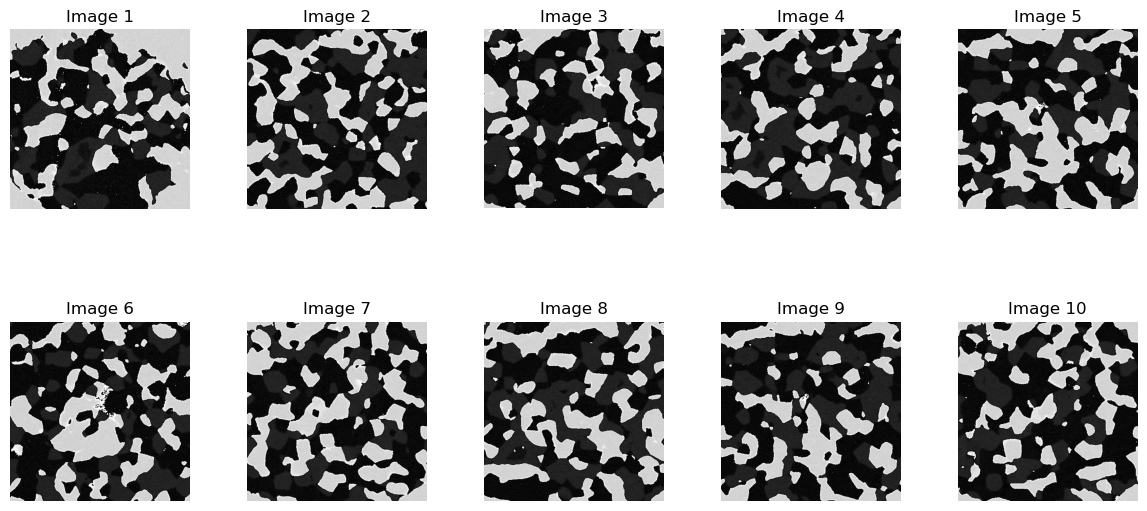

In [28]:
first_10_images = images_tensors[:10]  # Get the first 10 images

# Create a figure with tight layout
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
plt.tight_layout()

# Iterate through the images and display them in the subplots with titles
for i, ax in enumerate(axes.flat):
    if i < len(first_10_images):
        image = first_10_images[i][0]  # Remove the extra dimension
        ax.imshow(image, cmap='gray')  # Use 'cmap' to specify the colormap (e.g., 'gray' for grayscale)
        ax.axis('off')  # Turn off the axis labels
        ax.set_title(f"Image {i+1}", fontsize=12)  # Add a title with "Image 1", "Image 2", etc.

# Show the plot
plt.show()

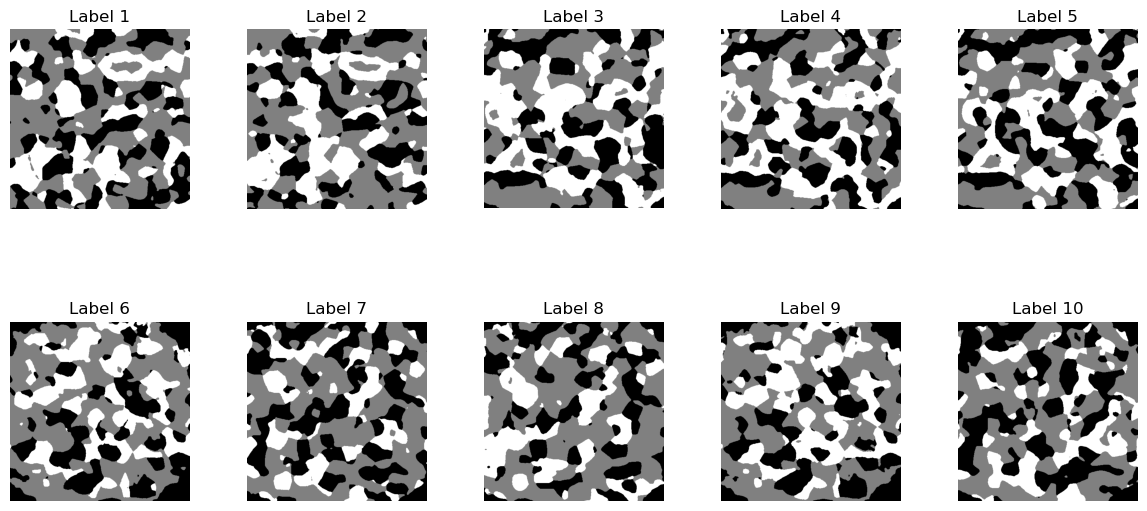

In [29]:
# Assuming you have a list of label images in the 'labels' variable
# labels[0] is the first label image, labels[1] is the second, and so on
label_images = labels_tensors[:10]  # Get the first 10 label images

# Create a figure with tight layout
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
plt.tight_layout()

# Iterate through the label images and display them in the subplots with titles
for i, ax in enumerate(axes.flat):
    if i < len(label_images):
        image = label_images[i][0]  # Remove the extra dimension
        ax.imshow(image, cmap='gray')  # Use 'cmap' to specify the colormap (e.g., 'gray' for grayscale)
        ax.axis('off')  # Turn off the axis labels
        ax.set_title(f"Label {i+1}", fontsize=12)  # Add a title with "Image 1", "Image 2", etc.

# Show the plot
plt.show()

## Build U-Net Model

Follow this example: https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3 

$\textbf{Number of Classes:}$

3 classes:
* Bright/white: The bright phase is nickel
* Gray: The gray phase is YSZ
* Dark: Pores and free space around the samples are dark

$\textbf{Encoder:}$

The encoder is a series of convolutional and pooling layers that progressively downsample the input image to extract features at multiple scales.

In the Encoder, the size of the image is gradually reduced while the depth gradually increases. This basically means the network learns the “WHAT” information in the image, however, it has lost the “WHERE” information.

Input image: (1 x 501 x 501)

* In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
* Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.

$\textbf{Decoder:}$

The decoder consists of a series of convolutional and upsampling layers that upsample the feature maps to the original input image size while also incorporating the high-resolution features from the encoder. This allows the decoder to produce segmentation masks that have the same size as the original input image.

In the Decoder, the size of the image gradually increases while the depth gradually decreases. This basically means the network learns the “WHERE” information in the image, by gradually applying up-sampling.

$\textbf{Final Layer:}$

At the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.

$\textbf{Forward method:}$

The forward method specifies how the input is processed through the network. The input image is first passed through the encoder layers to extract the features. Then, the decoder layers are used to upsample the features to the original image size while concatenating the corresponding encoder feature maps. Finally, the output layer uses a 1x1 convolutional layer to map the features to the desired number of output classes.

In [5]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [6]:
class Unet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder (downsampling)
        # input size: (1, 501, 501)
        self.e11 = Conv2d(1, 64, kernel_size=3, padding=1) # output: (64, 499, 499)
        self.e12 = Conv2d(64, 64, kernel_size=3, padding=1) # output: (64, 497, 497)
        self.pool1 = MaxPool2d(kernel_size=2, stride=2) # output: (64, 249, 249)

        # input size: (64, 249, 249)
        self.e21 = Conv2d(64, 128, kernel_size=3, padding=1) # output: (128, 247, 247)
        self.e22 = Conv2d(128, 128, kernel_size=3, padding=1) # output: (128, 245, 245)
        self.pool2 = MaxPool2d(kernel_size=2, stride=2) # output: (128, 122, 122)

        # input size: (128, 122, 122)
        self.e31 = Conv2d(128, 256, kernel_size=3, padding=1) # output: (256, 120, 120)
        self.e32 = Conv2d(256, 256, kernel_size=3, padding=1) # output: (256, 118, 118)
        self.pool3 = MaxPool2d(kernel_size=2, stride=2) # output: (256, 59, 59)

        # input size: (256, 59, 59)
        self.e41 = Conv2d(256, 512, kernel_size=3, padding=1) # output: (512, 57, 57)
        self.e42 = Conv2d(512, 512, kernel_size=3, padding=1) # output: (512, 55, 55)
        self.pool4 = MaxPool2d(kernel_size=2, stride=2) # output: (512, 27, 27)

        # input size: (512, 27, 27)
        self.e51 = Conv2d(512, 1024, kernel_size=3, padding=1) # output: (1024, 25, 25)
        self.e52 = Conv2d(1024, 1024, kernel_size=3, padding=1) # output: (1024, 23, 23)

        # Decoder (upsampling)

        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = Conv2d(64, n_class, kernel_size=1)


    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        #xu22 = torch.cat([xu2, xe32], dim=1)
        xu22 = torch.cat([xu2, xe32[:, :, :xu2.size(2), :xu2.size(3)]], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22[:, :, :xu3.size(2), :xu3.size(3)]], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12[:, :, :xu4.size(2), :xu4.size(3)]], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

net = Unet(3) # 3 classes
if use_cuda:
    net.cuda()

device = torch.device('cpu')  # use cuda or cpu
net.to(device)
print(net)

Unet(
  (e11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

## Define loss function and optimizer

In [7]:
# loss function: Cross entropy loss
# Consider categorical cross entropy loss for multi-class segmentation
loss_unet = nn.CrossEntropyLoss()

# optimizer: ADAM
optimizer_unet = optim.Adam(net.parameters(), lr=1e-3)

## Training, validation and test
* Train: 350 images
* Validation: 50 images
* Test: 100 images

In [8]:
train_images = images_tensors[:350]
train_labels = labels_tensors[:350]
val_images = images_tensors[350:400]
val_labels = labels_tensors[350:400]
test_images = images_tensors[400:]
test_labels = labels_tensors[400:]

In [30]:
images_tensors[0]

tensor([[[21357, 21656, 21301,  ..., 22812, 22163, 21752],
         [21227, 21316, 21023,  ..., 22191, 21908, 21856],
         [21292, 21180, 21098,  ..., 21435, 21353, 21517],
         ...,
         [22655, 22634, 22204,  ..., 21430, 21186, 20717],
         [22740, 22363, 21676,  ..., 20506, 20421, 20397],
         [22356, 21945, 21593,  ..., 20576, 20628, 20800]]], dtype=torch.int16)

## Test forward pass on dummy data

In [45]:
# Create a dummy input tensor
dummy_input = torch.randn(35, 1, 501, 501)  # (batch_size, channels, height, width)

# Forward pass
with torch.no_grad():
    if use_cuda:
        dummy_input = dummy_input.cuda()
    output = net(dummy_input)

# Print the output shape
print("Output shape:", output.shape)
#print(output)

KeyboardInterrupt: 

## Train the network

In the train data loader, we keep the shuffle parameter True since we want samples from all classes to be uniformly present in a batch which is important for optimal learning and convergence of batch gradient-based optimization approaches.

In [9]:
# batch size
batch_size = 35

# Create Tensor datasets
train_data = TensorDataset(torch.stack(train_images), torch.stack(train_labels))
val_data = TensorDataset(torch.stack(val_images), torch.stack(val_labels))
test_data = TensorDataset(torch.stack(test_images), torch.stack(test_labels))

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Get one batch of training data
images, labels = next(iter(train_loader))

# Print the image tensor shape
print("Image tensor shape:", images.shape)

Image tensor shape: torch.Size([35, 1, 501, 501])


In [10]:
import time

In [11]:
# number of epochs to train the model
n_epochs = 2

# Steps
train_steps = len(train_loader)//batch_size
val_steps = len(val_loader)//batch_size
test_steps = len(test_loader)//batch_size

# validation loss
valid_loss_min = np.Inf

# lists to store training and validation losses
train_losses = []
validation_losses = []

# lists to store training and validation accuracies
train_accuracies = []
validation_accuracies = []

net.train()

# start time (for printing elapsed time per epoch)
starttime = time.time()
for epoch in range(n_epochs):
    
    total_train_loss = 0
    total_val_loss = 0

    # loop over training data
    for images, labels in train_loader:
        # send the input to device
        images, labels = images.to(device), labels.to(device)
        images = images.to(torch.float32)
        # Complete forward pass through model
        output = net(images)

        # Compute the loss
        train_loss = loss_unet(output, labels)

        # clean up gradients from previous run
        optimizer_unet.zero_grad()

        # Compute gradients using back propagation
        train_loss.backward()

        # Take a step with the optimizer to update the weights
        optimizer_unet.step()

        # add the loss to the training set's running loss
        total_train_loss += train_loss

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        # set the model to evaluation mode
        net.eval()

        # loop over validation data
        for images, labels in val_loader:
            # send the input to device
            images, labels = images.to(device), labels.to(device)
            images = images.to(torch.float32)

            # Complete forward pass through model
            output = net(images)

            # Compute the loss
            val_loss = loss_unet(output, labels)

            # add the loss to the validation set's running loss 
            total_val_loss += val_loss

    # print training/validation statistics
    avg_train_loss = total_train_loss/train_steps
    avg_val_loss = total_val_loss/val_steps

    # update training history
    train_losses.append(avg_train_loss.cpu().numpy())
    validation_losses.append(avg_val_loss.cpu().numpy())

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, avg_train_loss, avg_val_loss))
    
# display time elapsed for epoch
endtime = time.time()
print(f"Elapsed time: {(endtime - starttime)/60:.2f} min")
print("Finished Training")



: 